I will use the Kolmogorov-Arnold Network as model for the classification for learning purposes   
- https://github.com/mintisan/awesome-kan
- https://kindxiaoming.github.io/pykan/intro.html
- https://medium.com/@zahmed333/what-is-the-new-neural-network-architecture-kan-kolmogorov-arnold-networks-explained-d2787b013ade

# Import 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import sklearn as sk
from sklearn import metrics, model_selection, pipeline, preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin

In [2]:
from kan import *

In [3]:
from sklearn.compose import ColumnTransformer

In [4]:
import pickle

# Config

## torch

In [5]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

## seed

In [6]:
RANDOM=42

## folders

In [7]:
ROOT = Path("../")
DATA = str(ROOT / "loan_data")
CACHE = str(ROOT / ".cache")
ENCODERS = str(ROOT/"encoders") 

## columms

In [8]:
TARGET_COL = "loan_status"

## dataset 

In [9]:
DATA_PATH = f'{DATA}/credit_risk_dataset.csv'

## encoders

In [10]:
ORDINAL_ENCODER_PATH = f"{ENCODERS}/ordinal_encoder.pkl"
ENCODERS_PATH = f"{ENCODERS}/label_encoders.pkl"

## splitting

In [11]:
SPLITS = 4
SHUFFLE = False  # required (time sensitive)
TEST_SIZE = 24 * 30 * 2 

## options

In [12]:
# force sklearn return pd.DataFrame
sk.set_config(transform_output="pandas")
pd.set_option("future.no_silent_downcasting", True)

# Datasets 

In [13]:
loan = pd.read_csv(DATA_PATH)
print("Hour:", loan.shape)
loan.head()

Hour: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [14]:
loan = loan.dropna(subset=['loan_int_rate', 'person_emp_length'])

In [15]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


## Preprocess 

### Encorders

In [16]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # Default mapping for binary variables
        self.mapping = mapping if mapping else {'Y': 1, 'N': 0}
    
    def fit(self, X, y=None):
        return self  # No fitting needed for mapping
    
    def transform(self, X):
        # Check if X is a pandas DataFrame or Series
        if not isinstance(X, (pd.DataFrame, pd.Series)):
            raise ValueError("Input must be a pandas DataFrame or Series")
        # Apply the mapping to the input data
        result = X.replace(self.mapping)
        result = result.infer_objects(copy=False)
        return result


class PreloadedLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoders):
        """
        Parameters:
        encoders (dict): Dictionary of preloaded LabelEncoder instances, keyed by column name.
        """
        self.encoders = encoders

    def fit(self, X, y=None):
        # No fitting required since encoders are pre-fitted
        return self

    def transform(self, X):
        # Apply the pre-fitted encoders to the specified columns
        X_transformed = X.copy()
        for col, _ in self.encoders.items():
            if col in X_transformed.columns:
                encoder = self.encoders[col]
                X_transformed[col] = encoder.fit_transform(X_transformed[col])
        return X_transformed

In [17]:
# load encoders
with open(ENCODERS_PATH, 'rb') as f:
    saved_encoders = pickle.load(f)

with open(ORDINAL_ENCODER_PATH, 'rb') as f:
    ordinal_encoder = pickle.load(f)

### Pipeline 

In [18]:
categorical_columns = loan.select_dtypes(exclude=[np.number]).columns
numeric_columns = loan.select_dtypes(include=[np.number]).columns 

In [19]:
assert all(
    col in loan.columns for col in numeric_columns
), "All numerical columns should be in inputs."

In [20]:
non_ordinal = ['person_home_ownership', "loan_intent"]
assert all(
    col in loan.columns for col in non_ordinal
), "All non-ordinal columns should be in categorical columns."

In [21]:
ordinal = ['loan_grade']
assert all(
    col in loan.columns for col in ordinal
), "All ordinal columns should be in categorical columns."

In [22]:
binary = ['cb_person_default_on_file']
assert all(
    col in loan.columns for col in binary
), "All binary columns should be in categorical columns."

In [31]:
class DataFrameToNumpy(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        return np.array(X)  # Convert DataFrame to NumPy array

In [32]:
transformation_pipeline = ColumnTransformer(
                transformers=[
                    # Label_encoder for non-ordinal categorical features
                    (
                        "non_ordinal", PreloadedLabelEncoder(saved_encoders), non_ordinal,
                    ),
                    #  binary features (e.g., Y/N)
                    (
                        "binary", BinaryEncoder(), binary,
                    ),
                    # Pass numeric columns without changes
                    ("numericals", "passthrough", numeric_columns),
                ],
                remainder="drop",  # Drop columns not specified in transformers
                verbose_feature_names_out=False
            )

In [33]:
# Create the pipeline
pipe = pipeline.Pipeline(
    steps=[
        ("transformer", transformation_pipeline),
        #  ("to_numpy", DataFrameToNumpy()),
    ],
    memory=None,  
)

In [34]:
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('non_ordinal',
                                                  PreloadedLabelEncoder(encoders={'loan_intent': LabelEncoder(),
                                                                                  'person_home_ownership': LabelEncoder()}),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('binary',
                                                  BinaryEncoder(mapping={'N': 0,
                                                                         'Y': 1}),
                                                  ['cb_person_default_on_file']),
                                                 ('numericals', 'passthrough',
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

In [57]:
tranformed_data = pipe.fit_transform(loan)

## Subsets 

In [58]:
inputs, targets = tranformed_data.drop(columns=TARGET_COL), loan[TARGET_COL]
print("Inputs:", inputs.shape, "; Targets:", targets.shape)

Inputs: (28638, 10) ; Targets: (28638,)


In [59]:
inputs_train, inputs_test, targets_train, targets_test = model_selection.train_test_split(
    inputs, targets, shuffle=SHUFFLE, test_size=TEST_SIZE, random_state=RANDOM)

print("[TRAIN] Inputs:", inputs_train.shape, "; Targets:", targets_train.shape)
print("[TEST] Inputs:", inputs_test.shape, "; Targets:", targets_test.shape)

[TRAIN] Inputs: (27198, 10) ; Targets: (27198,)
[TEST] Inputs: (1440, 10) ; Targets: (1440,)


In [38]:
assert (
    inputs_train.index.max() < inputs_test.index.min()
), "Inputs train should be before inputs test"
assert (
    targets_train.index.max() < targets_test.index.min()
), "Targets train should be before targets test"

# MODELS

## T-SNE

just for visualisation purpose 

In [28]:
from sklearn.manifold import TSNE

In [29]:
# Step 2: Preprocess the data (scaling)
scaler = preprocessing.StandardScaler()
data_scaled = scaler.fit_transform(tranformed_data)

In [30]:
# Step 3: Perform t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM, perplexity=30, learning_rate=200, max_iter=1000)
data_tsne = tsne.fit_transform(data_scaled)

In [32]:
tsne = pd.concat([data_tsne, targets_train], axis=1)

In [34]:
fig = px.scatter(tsne, x="tsne0", y="tsne1", color="loan_status")
fig.show()

## KAN Model 

In [39]:
#
dataset = {}
dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(inputs_train.values).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(inputs_test.values).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(targets_train.values[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(targets_test.values[:,None]).type(dtype).to(device)

In [40]:
# test pykan model 
model = KAN(width=[10,1], grid=3, k=2, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

checkpoint directory created: ./model
saving model version 0.0


In [41]:
results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), lamb_entropy=1)

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 3.78e-01 | test_loss: 4.77e-01 | reg: 1.37e+00 | : 100%|█| 20/20 [00:04<00:00,  4.84it

saving model version 0.1


In [42]:
results["train_acc"][-1], results["test_acc"][-1]

(0.7996176481246948, 0.8104166388511658)

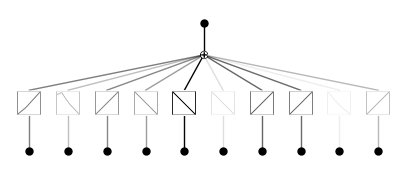

In [43]:
model.plot()

In [44]:
dataset['train_input'].shape[1]

10

# GridSearch

In [45]:
class KanClassifier(ClassifierMixin, BaseEstimator ):
    def __init__(self, width=[10, 1], grid=3, k=2, steps=20, lamb_entropy=1.0, opt="LBFGS", device=None):
        """
        Wrapper pour le modèle Kolmogorov-Arnold Network (KAN) compatible avec scikit-learn.
        
        Paramètres:
          - width: liste définissant la largeur des couches (exemple : [10, 1])
          - grid: paramètre du modèle
          - k: paramètre du modèle
          - steps: nombre d'itérations (steps) pour l'entraînement
          - lamb_entropy: coefficient de régularisation (lamb_entropy)
          - opt: algorithme d'optimisation (ici, "LBFGS" par défaut)
          - device: appareil sur lequel exécuter torch (par défaut, utilise CUDA ou CPU)
        """
        self.width = width
        self.grid = grid
        self.k = k
        self.steps = steps
        self.lamb_entropy = lamb_entropy
        self.opt = opt
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        self.model_ = None  # l'attribut contiendra le modèle entraîné

    def fit(self, X, y):
        """
        Entraîne le modèle KAN sur les données fournies.
        """
        # Conversion éventuelle de DataFrame / Series en numpy
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values

        # S'assurer que y est de dimension (n_samples, 1)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        # separer les donnees en respectant en X_train, X_test, y_train, y_test
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                            shuffle=SHUFFLE, 
                                                                            test_size=TEST_SIZE, 
                                                                            random_state=RANDOM)

        # Conversion en tenseurs torch avec le type par défaut
        dtype = torch.get_default_dtype()
        X_train_tensor = torch.from_numpy(X_train).type(dtype).to(self.device)
        X_test_tensor = torch.from_numpy(X_test).type(dtype).to(self.device)
        y_train_tensor = torch.from_numpy(y_train).type(dtype).to(self.device)
        y_test_tensor = torch.from_numpy(y_test).type(dtype).to(self.device)


        # Création du modèle KAN avec les hyperparamètres
        self.model_ = KAN(width=self.width, grid=self.grid, k=self.k, device=self.device)

        # Préparer le dictionnaire de données pour l'entraînement
        dataset = {
            'train_input': X_train_tensor,
            'train_label': X_test_tensor,
            'test_input': y_train_tensor,   
            'test_label': y_test_tensor      
        }

        # Entraînement du modèle
        self.model_.fit(dataset, opt=self.opt, steps=self.steps, lamb_entropy=self.lamb_entropy)

        # Set the classes_ attribute based on y.
        self.classes_ = np.unique(y)
        
        return self
        

    def predict(self, X):
        if self.model_ is None:
            raise ValueError("Le modèle n'est pas encore entraîné. Veuillez appeler fit() d'abord.")

        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values

        dtype = torch.get_default_dtype()
        X_tensor = torch.from_numpy(X).type(dtype).to(self.device)

        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)

        # Pour macOS (avec MPS), on détache le tenseur, on le transfère sur CPU, puis on convertit en numpy
        predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)
        return predictions

    def score(self, X, y):
        """
        Calcule l'accuracy en comparant les prédictions aux cibles.
        """
        y_pred = self.predict(X)
        return metrics.accuracy_score(y, y_pred)

In [50]:
# Définir une grille d'hyperparamètres à explorer
param_grid = {
    "width": [[inputs_train.shape[1], 1], [inputs_train.shape[1],5,1]], 
    "grid": [4,5], 
    "k": [3, 4],  
    "steps": [20, 30 ], 
    "lamb_entropy": [1.0, 2.0], 
}

In [51]:
kan_clf = KanClassifier(device=device)

# Création du GridSearchCV
grid_search = GridSearchCV(
    estimator=kan_clf,
    param_grid=param_grid,
    cv=3,                # validation croisée à 3 plis (à ajuster selon vos données)
    scoring="accuracy",  # ou toute autre métrique adaptée
    verbose=3,
)

In [52]:
# Lancer le grid search sur vos données d'entraînement
grid_search.fit(inputs_train, targets_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:10<00:00,  1.98it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=  10.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:09<00:00,  2.19it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=   9.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.77e-01 | test_loss: 3.77e-01 | reg: 1.29e+00 | : 100%|█| 20/20 [00:04<00:00,  4.86it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=   4.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.89e-01 | test_loss: 3.89e-01 | reg: 7.18e+01 | : 100%|█| 20/20 [00:17<00:00,  1.17it


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  17.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.82e-01 | test_loss: 7.82e-01 | reg: 1.04e+01 | : 100%|█| 20/20 [00:08<00:00,  2.33it


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.526 total time=   8.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.70e-01 | test_loss: 3.70e-01 | reg: 9.16e+00 | : 100%|█| 20/20 [00:18<00:00,  1.08it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.810 total time=  18.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:14<00:00,  2.12it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  14.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:13<00:00,  2.19it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  13.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 1.36e+00 | : 100%|█| 30/30 [00:06<00:00,  4.62it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.789 total time=   6.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.94e-01 | test_loss: 3.94e-01 | reg: 6.01e+01 | : 100%|█| 30/30 [00:20<00:00,  1.44it


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  20.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.86e-01 | test_loss: 3.86e-01 | reg: 1.05e+01 | : 100%|█| 30/30 [00:17<00:00,  1.71it


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.783 total time=  17.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.65e-01 | test_loss: 3.65e-01 | reg: 9.18e+00 | : 100%|█| 30/30 [00:31<00:00,  1.04s/


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.815 total time=  31.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:09<00:00,  2.14it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=   9.4s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:09<00:00,  2.17it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=   9.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.77e-01 | test_loss: 3.77e-01 | reg: 2.32e+00 | : 100%|█| 20/20 [00:04<00:00,  4.79it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=   4.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.89e-01 | test_loss: 3.89e-01 | reg: 7.49e+01 | : 100%|█| 20/20 [00:17<00:00,  1.15it


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  17.4s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.82e-01 | test_loss: 7.82e-01 | reg: 1.45e+01 | : 100%|█| 20/20 [00:07<00:00,  2.64it


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.526 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.70e-01 | test_loss: 3.70e-01 | reg: 1.25e+01 | : 100%|█| 20/20 [00:18<00:00,  1.07it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.810 total time=  18.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:13<00:00,  2.30it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  13.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:13<00:00,  2.25it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  13.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 2.44e+00 | : 100%|█| 30/30 [00:06<00:00,  4.39it


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.789 total time=   6.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.94e-01 | test_loss: 3.94e-01 | reg: 6.32e+01 | : 100%|█| 30/30 [00:22<00:00,  1.35it


saving model version 0.1
[CV 1/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  22.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.86e-01 | test_loss: 3.86e-01 | reg: 1.40e+01 | : 100%|█| 30/30 [00:18<00:00,  1.66it


saving model version 0.1
[CV 2/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.783 total time=  18.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.65e-01 | test_loss: 3.65e-01 | reg: 1.25e+01 | : 100%|█| 30/30 [00:30<00:00,  1.02s/


saving model version 0.1
[CV 3/3] END grid=4, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.815 total time=  30.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:12<00:00,  1.54it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=  13.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:12<00:00,  1.55it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=  12.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 1.28e+00 | : 100%|█| 20/20 [00:05<00:00,  3.60it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.781 total time=   5.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.29e+01 | : 100%|█| 20/20 [00:19<00:00,  1.02it


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  19.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.01e-01 | test_loss: 9.01e-01 | reg: 1.05e+01 | : 100%|█| 20/20 [00:07<00:00,  2.62it


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.442 total time=   7.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 8.16e-01 | reg: 1.05e+01 | : 100%|█| 20/20 [00:05<00:00,  3.34it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.373 total time=   6.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:18<00:00,  1.65it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  18.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:18<00:00,  1.66it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  18.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 1.27e+00 | : 100%|█| 30/30 [00:07<00:00,  3.82it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.781 total time=   7.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.28e+01 | : 100%|█| 30/30 [00:23<00:00,  1.25it


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  24.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.01e-01 | test_loss: 9.01e-01 | reg: 1.05e+01 | : 100%|█| 30/30 [00:10<00:00,  2.83it


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.442 total time=  10.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 8.16e-01 | reg: 1.05e+01 | : 100%|█| 30/30 [00:07<00:00,  3.92it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.373 total time=   7.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:12<00:00,  1.64it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=  12.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:13<00:00,  1.48it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=  13.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 2.31e+00 | : 100%|█| 20/20 [00:06<00:00,  3.05it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.781 total time=   6.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.61e+01 | : 100%|█| 20/20 [00:21<00:00,  1.08s/


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  21.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.01e-01 | test_loss: 9.01e-01 | reg: 1.46e+01 | : 100%|█| 20/20 [00:07<00:00,  2.65it


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.442 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 8.16e-01 | reg: 1.46e+01 | : 100%|█| 20/20 [00:05<00:00,  3.78it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.373 total time=   5.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:18<00:00,  1.60it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  18.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:17<00:00,  1.70it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  17.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 2.30e+00 | : 100%|█| 30/30 [00:07<00:00,  3.96it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.781 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.60e+01 | : 100%|█| 30/30 [00:26<00:00,  1.12it


saving model version 0.1
[CV 1/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  27.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.01e-01 | test_loss: 9.01e-01 | reg: 1.46e+01 | : 100%|█| 30/30 [00:12<00:00,  2.41it


saving model version 0.1
[CV 2/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.442 total time=  12.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 8.16e-01 | reg: 1.46e+01 | : 100%|█| 30/30 [00:09<00:00,  3.11it


saving model version 0.1
[CV 3/3] END grid=4, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.373 total time=   9.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:11<00:00,  1.77it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=  11.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.81e-01 | test_loss: 3.81e-01 | reg: 1.31e+00 | : 100%|█| 20/20 [00:07<00:00,  2.66it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.797 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 1.19e+00 | : 100%|█| 20/20 [00:07<00:00,  2.65it


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.791 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 1.90e+01 | : 100%|█| 20/20 [00:34<00:00,  1.73s/


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.814 total time=  34.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.06e-01 | test_loss: 4.06e-01 | reg: 9.82e+00 | : 100%|█| 20/20 [00:07<00:00,  2.69it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.782 total time=   7.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.69e-01 | test_loss: 3.69e-01 | reg: 1.41e+01 | : 100%|█| 20/20 [00:23<00:00,  1.16s/


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.810 total time=  23.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:14<00:00,  2.07it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  14.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.81e-01 | test_loss: 3.81e-01 | reg: 1.31e+00 | : 100%|█| 30/30 [00:06<00:00,  4.82it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.797 total time=   6.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 1.19e+00 | : 100%|█| 30/30 [00:05<00:00,  5.35it


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.791 total time=   5.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.66e-01 | test_loss: 3.66e-01 | reg: 2.31e+01 | : 100%|█| 30/30 [00:33<00:00,  1.13s/


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.819 total time=  33.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.06e-01 | test_loss: 4.06e-01 | reg: 9.82e+00 | : 100%|█| 30/30 [00:09<00:00,  3.22it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.782 total time=   9.4s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 1.52e+01 | : 100%|█| 30/30 [00:34<00:00,  1.15s/


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.814 total time=  34.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:11<00:00,  1.75it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=  11.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.81e-01 | test_loss: 3.81e-01 | reg: 2.35e+00 | : 100%|█| 20/20 [00:05<00:00,  3.43it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.797 total time=   5.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.15e+00 | : 100%|█| 20/20 [00:04<00:00,  4.14it


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.791 total time=   4.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 2.25e+01 | : 100%|█| 20/20 [00:23<00:00,  1.18s/


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.814 total time=  23.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.06e-01 | test_loss: 4.06e-01 | reg: 1.33e+01 | : 100%|█| 20/20 [00:07<00:00,  2.67it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.782 total time=   7.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.69e-01 | test_loss: 3.69e-01 | reg: 1.78e+01 | : 100%|█| 20/20 [00:25<00:00,  1.26s/


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.810 total time=  25.2s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:15<00:00,  1.92it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  15.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.81e-01 | test_loss: 3.81e-01 | reg: 2.35e+00 | : 100%|█| 30/30 [00:06<00:00,  4.44it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.797 total time=   6.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-01 | test_loss: 3.83e-01 | reg: 2.15e+00 | : 100%|█| 30/30 [00:06<00:00,  4.96it


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.791 total time=   6.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.66e-01 | test_loss: 3.66e-01 | reg: 2.64e+01 | : 100%|█| 30/30 [00:32<00:00,  1.09s/


saving model version 0.1
[CV 1/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.819 total time=  32.9s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.06e-01 | test_loss: 4.06e-01 | reg: 1.33e+01 | : 100%|█| 30/30 [00:09<00:00,  3.08it


saving model version 0.1
[CV 2/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.782 total time=   9.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 1.89e+01 | : 100%|█| 30/30 [00:36<00:00,  1.23s/


saving model version 0.1
[CV 3/3] END grid=5, k=3, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.814 total time=  36.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:16<00:00,  1.18it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.782 total time=  17.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.08e-01 | test_loss: 4.08e-01 | reg: 1.52e+00 | : 100%|█| 20/20 [00:09<00:00,  2.08it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.783 total time=   9.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-01 | test_loss: 3.74e-01 | reg: 1.24e+00 | : 100%|█| 20/20 [00:06<00:00,  2.87it


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 1];, score=0.795 total time=   7.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 8.83e+01 | : 100%|█| 20/20 [00:37<00:00,  1.87s/


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  37.4s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.17e-01 | test_loss: 4.17e-01 | reg: 9.80e+00 | : 100%|█| 20/20 [00:14<00:00,  1.40it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.782 total time=  14.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.69e-01 | test_loss: 3.69e-01 | reg: 1.75e+01 | : 100%|█| 20/20 [00:35<00:00,  1.75s/


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=1.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  35.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:21<00:00,  1.39it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.782 total time=  21.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 1.30e+00 | : 100%|█| 30/30 [00:10<00:00,  2.87it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.800 total time=  10.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-01 | test_loss: 3.74e-01 | reg: 1.24e+00 | : 100%|█| 30/30 [00:07<00:00,  3.98it


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 1];, score=0.795 total time=   7.6s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.68e-01 | test_loss: 3.68e-01 | reg: 4.59e+02 | : 100%|█| 30/30 [00:51<00:00,  1.71s/


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.821 total time=  51.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.17e-01 | test_loss: 4.17e-01 | reg: 9.80e+00 | : 100%|█| 30/30 [00:14<00:00,  2.11it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.782 total time=  14.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.70e-01 | test_loss: 3.70e-01 | reg: 1.78e+01 | : 100%|█| 30/30 [00:44<00:00,  1.50s/


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=1.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  45.0s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:13<00:00,  1.46it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.782 total time=  13.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.08e-01 | test_loss: 4.08e-01 | reg: 2.72e+00 | : 100%|█| 20/20 [00:06<00:00,  3.13it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.783 total time=   6.4s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-01 | test_loss: 3.74e-01 | reg: 2.22e+00 | : 100%|█| 20/20 [00:06<00:00,  3.01it


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 1];, score=0.795 total time=   6.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.67e-01 | test_loss: 3.67e-01 | reg: 9.12e+01 | : 100%|█| 20/20 [00:34<00:00,  1.72s/


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  34.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.17e-01 | test_loss: 4.17e-01 | reg: 1.33e+01 | : 100%|█| 20/20 [00:09<00:00,  2.04it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.782 total time=   9.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.69e-01 | test_loss: 3.69e-01 | reg: 2.10e+01 | : 100%|█| 20/20 [00:32<00:00,  1.63s/


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=2.0, steps=20, width=[10, 5, 1];, score=0.813 total time=  32.7s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [00:20<00:00,  1.44it/s]
/var/folders/gw/94vcjq655895gr9p6y2j1h580000gn/T/ipykernel_88840/3017981961.py:82: RuntimeWarning: invalid value encountered in cast
  predictions = torch.round(outputs[:, 0].detach()).to('cpu').numpy().astype(int)


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.782 total time=  20.8s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.78e-01 | reg: 2.34e+00 | : 100%|█| 30/30 [00:10<00:00,  2.97it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.800 total time=  10.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-01 | test_loss: 3.74e-01 | reg: 2.22e+00 | : 100%|█| 30/30 [00:07<00:00,  4.13it


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 1];, score=0.795 total time=   7.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.68e-01 | test_loss: 3.68e-01 | reg: 4.61e+02 | : 100%|█| 30/30 [00:48<00:00,  1.62s/


saving model version 0.1
[CV 1/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.821 total time=  48.5s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.17e-01 | test_loss: 4.17e-01 | reg: 1.33e+01 | : 100%|█| 30/30 [00:16<00:00,  1.84it


saving model version 0.1
[CV 2/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.782 total time=  16.3s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.70e-01 | test_loss: 3.70e-01 | reg: 2.13e+01 | : 100%|█| 30/30 [00:52<00:00,  1.74s/


saving model version 0.1
[CV 3/3] END grid=5, k=4, lamb_entropy=2.0, steps=30, width=[10, 5, 1];, score=0.813 total time=  52.1s
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.73e-01 | test_loss: 3.73e-01 | reg: 1.55e+01 | : 100%|█| 30/30 [01:18<00:00,  2.61s/

saving model version 0.1


GridSearchCV(cv=3, estimator=KanClassifier(device=device(type='cpu')),
             param_grid={'grid': [4, 5], 'k': [3, 4],
                         'lamb_entropy': [1.0, 2.0], 'steps': [20, 30],
                         'width': [[10, 1], [10, 5, 1]]},
             scoring='accuracy', verbose=3)

In [54]:
# Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

# --- Utilisation du meilleur modèle sur le test ---
best_model = grid_search.best_estimator_
accuracy_test = best_model.score(inputs_test, targets_test)
print("Accuracy sur le jeu de test :", accuracy_test)

Meilleurs paramètres : {'grid': 5, 'k': 4, 'lamb_entropy': 1.0, 'steps': 30, 'width': [10, 5, 1]}
Meilleur score : 0.8053533348040297
Accuracy sur le jeu de test : 0.8138888888888889


# INFERENCE

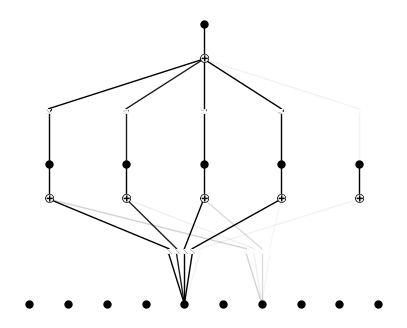

In [67]:
best_model.model_.plot()